In [1]:
import numpy as np
import scipy.io
import scipy.linalg
import sklearn.metrics
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import torch
from torch import nn

import ipdb

In [2]:
def kernel(ker, X1, X2, gamma):
    K = None
    if not ker or ker == 'primal':
        K = X1
    elif ker == 'linear':
        if X2 is not None:
            # next line: K = X1.T@X2
            K = sklearn.metrics.pairwise.linear_kernel(np.asarray(X1).T, np.asarray(X2).T)
        else:
            K = X1.T@X1
    elif ker == 'rbf':
        if X2 is not None:
            K = sklearn.metrics.pairwise.rbf_kernel(np.asarray(X1).T, np.asarray(X2).T, gamma)
        else:
            K = sklearn.metrics.pairwise.rbf_kernel(np.asarray(X1).T, None, gamma)
    return K

In [3]:
def get_f_domain(T, sampling_rate=10):
    # T should be n, 1
    f = T
    numSamples = f.size
    # Get Fourier Transform
    F = np.fft.fft(f);
    F = np.fft.fftshift(F);

    # Get the frequency axis
    w = np.fft.fftfreq(numSamples, d=1/sampling_rate);
    # Shift frequency to be centered about the y-axis
    w = np.fft.fftshift(w);

    # Get magnitude and phase
    MagF = np.abs(F)
    PhaseF = np.angle(F)
    
    return MagF, PhaseF, w, F

In [4]:
def get_t_domain(F):
    # Reconstruct with IFFT, F should be n, 1
    F = np.fft.ifftshift(F); # Undo shifting of frequency before IFFT!!!
    fRecon = np.fft.ifft(F);
    
    return fRecon

In [5]:
class TCA:
    def __init__(self, kernel_type='primal', dim=30, lamb=1, gamma=1):
        '''
        Init func
        :param kernel_type: kernel, values: 'primal' | 'linear' | 'rbf'
        :param dim: dimension after transfer
        :param lamb: lambda value in equation
        :param gamma: kernel bandwidth for rbf kernel
        '''
        self.kernel_type = kernel_type
        self.dim = dim
        self.lamb = lamb
        self.gamma = gamma

    def fit(self, Xs, Xt):
        '''
        Transform Xs and Xt
        :param Xs: ns * n_feature, source feature
        :param Xt: nt * n_feature, target feature
        :return: Xs_new and Xt_new after TCA
        '''
        X = np.hstack((Xs.T, Xt.T)).astype('complex128')
        X /= np.linalg.norm(X, axis=0)
        m, n = X.shape
        ns, nt = len(Xs), len(Xt)
        e = np.vstack((1 / ns * np.ones((ns, 1)), -1 / nt * np.ones((nt, 1))))
        L = e * e.T
        L = L / np.linalg.norm(L, 'fro')
        H = np.eye(n) - 1 / n * np.ones((n, n))  # page 202
        K = kernel(self.kernel_type, X, None, gamma=self.gamma)
        n_eye = m if self.kernel_type == 'primal' else n
        a, b = np.linalg.multi_dot([K, L, K.T]) + self.lamb * np.eye(n_eye), np.linalg.multi_dot([K, H, K.T])
        w, V = scipy.linalg.eig(a, b)
        ind = np.argsort(w)
        A = V[:, ind[:self.dim]]
        Z = np.dot(A.T, K)
        Z /= np.linalg.norm(Z, axis=0)
        Xs_new, Xt_new = Z[:, :ns].T, Z[:, ns:].T
        return Xs_new, Xt_new, A

    def fit_predict(self, Xs, Ys, Xt, Yt):
        '''
        Transform Xs and Xt, then make predictions on target using 1NN
        :param Xs: ns * n_feature, source feature
        :param Ys: ns * 1, source label
        :param Xt: nt * n_feature, target feature
        :param Yt: nt * 1, target label
        :return: Accuracy and predicted_labels on the target domain
        '''
        Xs_new, Xt_new = self.fit(Xs, Xt)
        clf = KNeighborsClassifier(n_neighbors=1)
        clf.fit(Xs_new, Ys.ravel())
        y_pred = clf.predict(Xt_new)
        acc = sklearn.metrics.accuracy_score(Yt, y_pred)
        return acc, y_pred, Xs_new, Xt_new

In [6]:
def normalize(V):
    return ( V - min(V.flatten()) ) / ( max(V.flatten()) - min(V.flatten()) )

In [7]:
def sliding_window(T, T_org, batch_size, inp_dim, label_dim):

    # inp_dim is equal to window_size
    # T (np.array) has dim: seq_len, feature
    TT = T.reshape(-1, 1)
    TT_org = T_org.reshape(-1, 1)
    K = TT.shape[0] - inp_dim - label_dim + 1

    # TT has dim: n, 1
    train_x = np.vstack(TT[i : K+i, 0] for i in range(inp_dim)).T
    train_y = np.vstack(TT_org[i+inp_dim : K+inp_dim+i, 0] for i in range(label_dim)).T
    
    assert train_x.shape[0] == train_y.shape[0]
    #ipdb.set_trace()
    batch_volume = train_x.shape[0]//batch_size
    
    org_shape = train_x.shape[0]
    train_x = train_x[:org_shape-org_shape%batch_size, :]
    #train_x = train_x.reshape(batch_volume, batch_size, inp_dim)
    train_y = train_y[:org_shape-org_shape%batch_size, :]
    #train_y = train_y.reshape(batch_volume, batch_size, label_dim)
    
    return train_x, train_y


In [8]:
data = np.array(pd.read_csv('4577_aug19-aug31.csv'))

src1 = data[180:221, :]
src2 = data[271:271, :]
src = np.vstack([src1, src2])
tgt = data[221:271-40, :]

src = normalize(src)
tgt = normalize(tgt)

src_domain  = src
src_domain_org = src
tar_domain = tgt
tar_domain_org = tgt

batch_size, inp_dim, label_dim = 96, 5, 1

# train_x and train_y would be used for training the network
train_x, train_y = sliding_window(src_domain, src_domain_org, batch_size, inp_dim, label_dim)
test_x, test_y = sliding_window(tar_domain, tar_domain_org, batch_size, inp_dim, label_dim)


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  # This is added back by InteractiveShellApp.init_path()


In [9]:
train_x.shape

(3840, 5)

In [10]:
tca = TCA(kernel_type='linear', dim=train_x.shape[1], lamb=1, gamma=1)
Xs_new, Xt_new, A = tca.fit(train_x, test_x)  # Xs_new and Xt_new are in frequency domain

# Learning Part

In [11]:
class LSTM(nn.Module):
    def __init__(self, inp_dim, out_dim, hid_dim, layers):
        super(LSTM, self).__init__()

        self.out_dim = out_dim
        
        self.lstm = nn.LSTM(inp_dim, hid_dim, layers, dropout=0.1)
        
        self.fc = nn.Sequential(
            nn.Linear(hid_dim, out_dim)
        )  # regression
    
    def forward(self, x):
        # input: (seq_len, batchsize, input_size)
        # output: (seq_len, batchsize, hid_dim)
        #ipdb.set_trace()
        y = self.lstm(x)[0]  # y, (h, c) = self.rnn(x)

        seq_len, batch_size, hid_dim = y.shape
        
        y = y.view(-1, hid_dim)
        y = self.fc(y)  # fully connected layer
        y = y.view(seq_len, batch_size, -1)
        assert y.shape[2] == self.out_dim
        
        return y


In [12]:
# build model
hid_dim, layers = 4, 3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = LSTM(inp_dim, label_dim, hid_dim, layers).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
#scheduler =  torch.optim.lr_scheduler.StepLR(optimizer, 0.7)

Epoch:    0, Loss: 0.63744


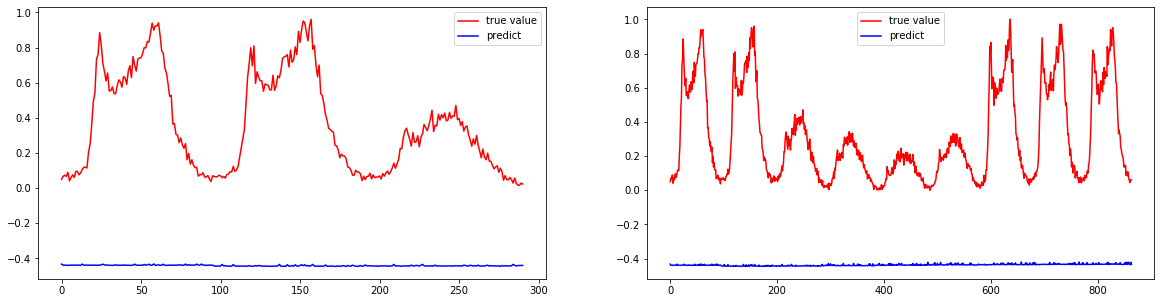

Epoch:  100, Loss: 0.05722


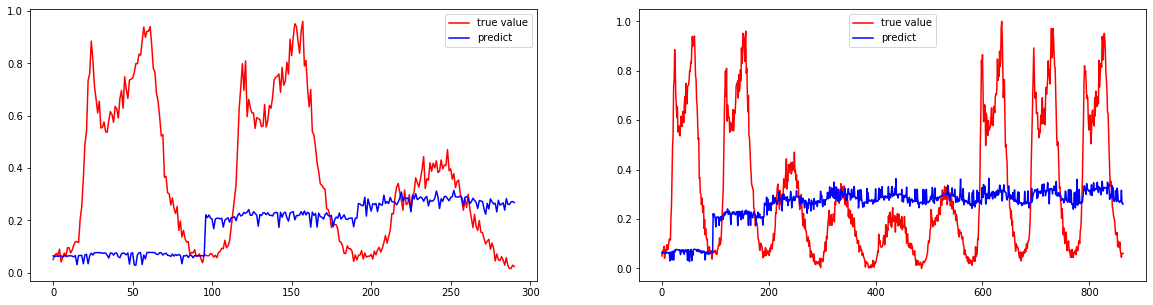

Epoch:  200, Loss: 0.00900


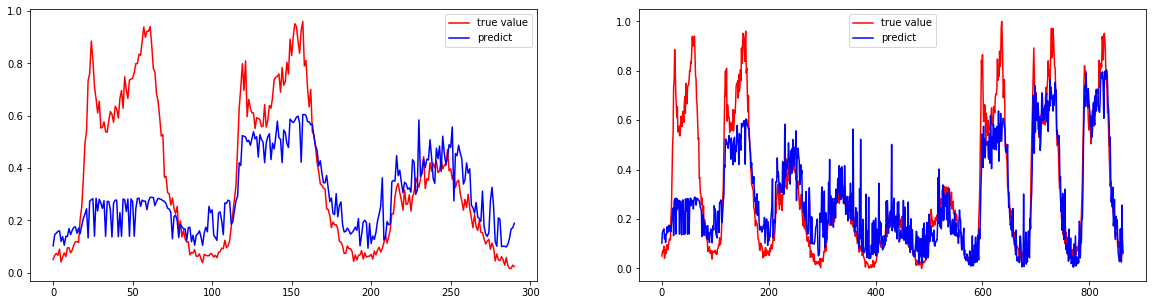

Epoch:  300, Loss: 0.00574


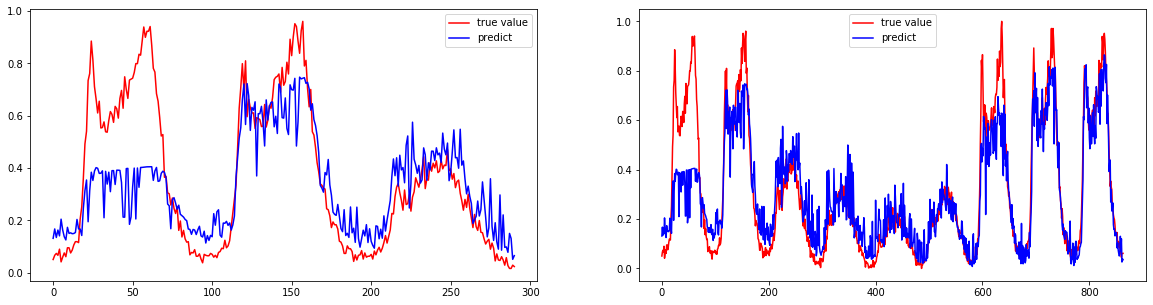

Epoch:  400, Loss: 0.00421


Epoch:  500, Loss: 0.00359


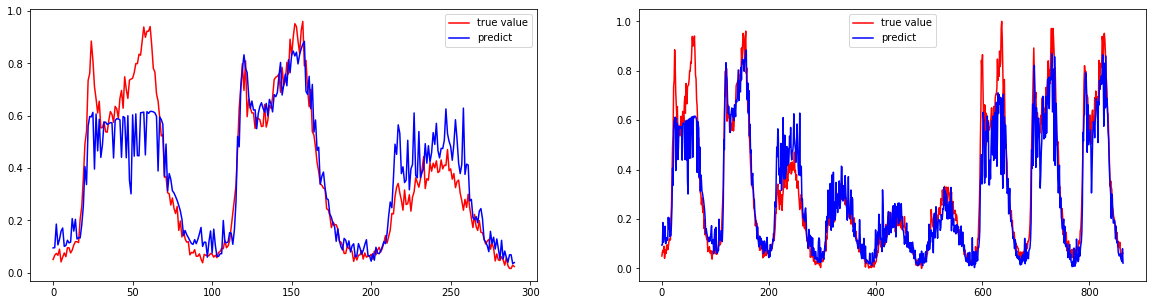

Epoch:  600, Loss: 0.00323


Epoch:  700, Loss: 0.00310


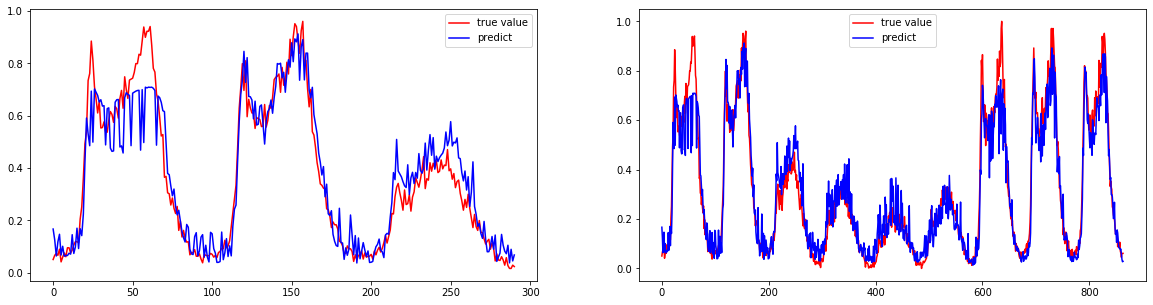

Epoch:  800, Loss: 0.00301


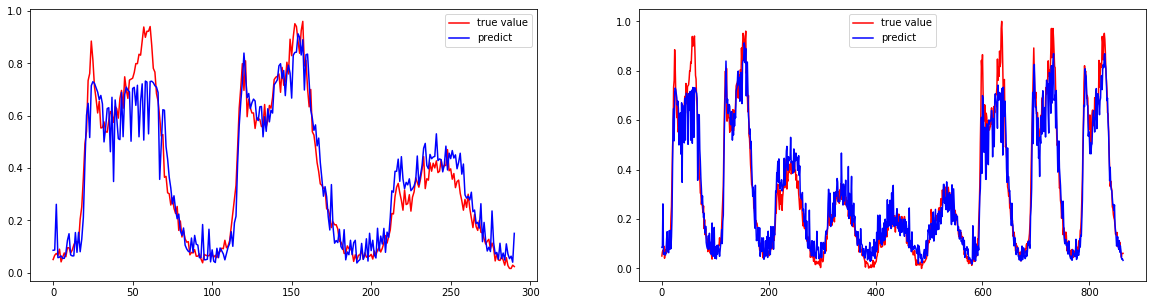

Epoch:  900, Loss: 0.00273


Epoch: 1000, Loss: 0.00269


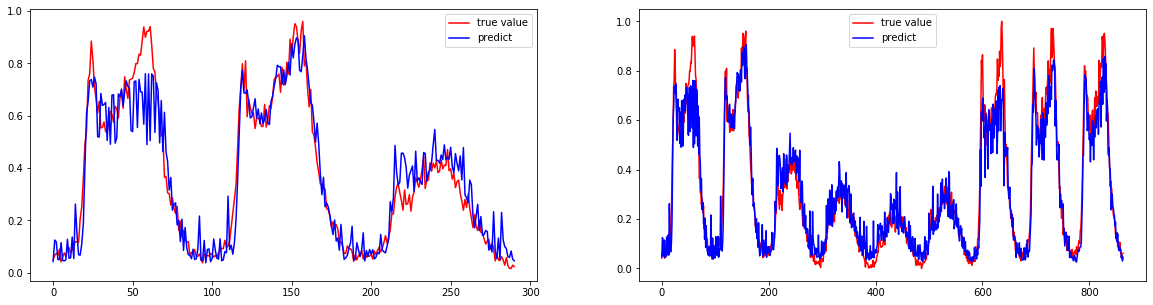

Epoch: 1100, Loss: 0.00285


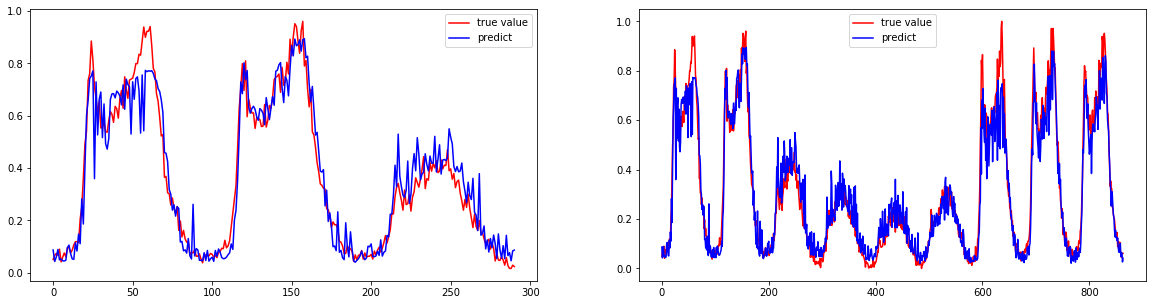

Epoch: 1200, Loss: 0.00287


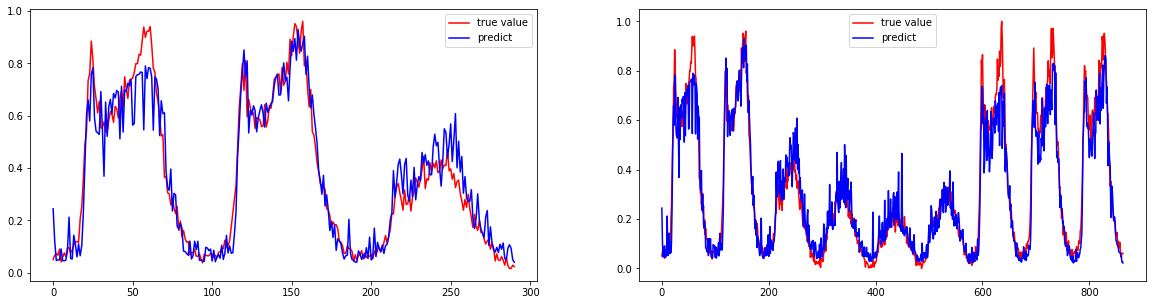

Epoch: 1300, Loss: 0.00261


Epoch: 1400, Loss: 0.00269


Epoch: 1500, Loss: 0.00263


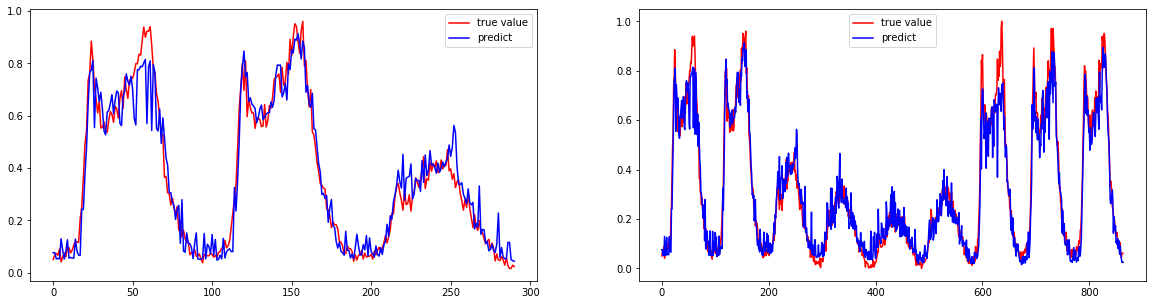

Epoch: 1600, Loss: 0.00257


Epoch: 1700, Loss: 0.00263


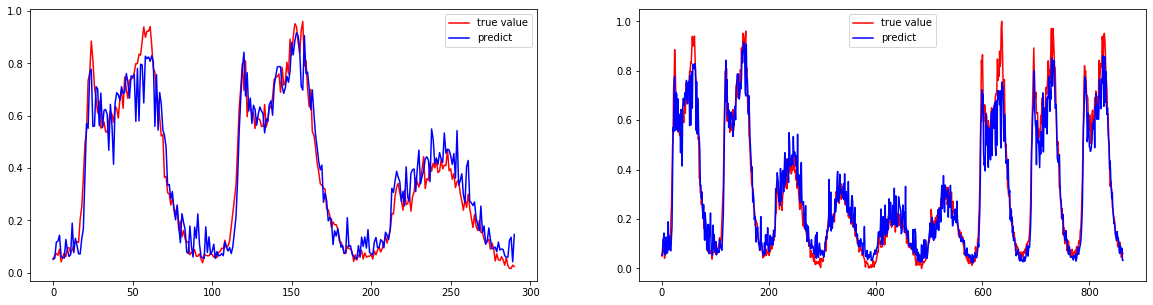

Epoch: 1800, Loss: 0.00255


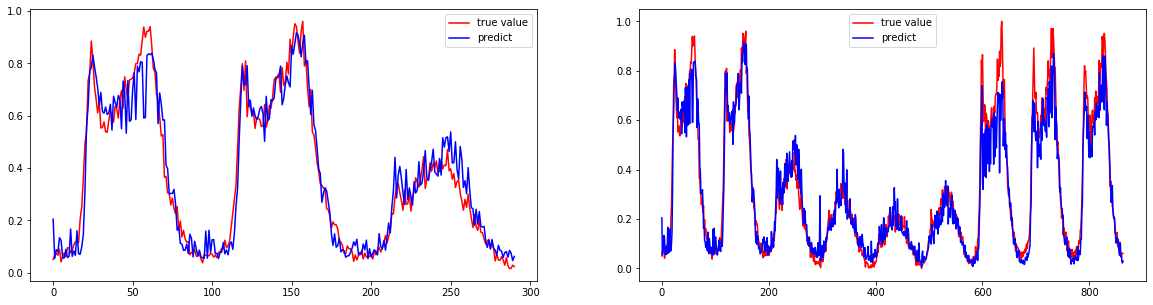

Epoch: 1900, Loss: 0.00256


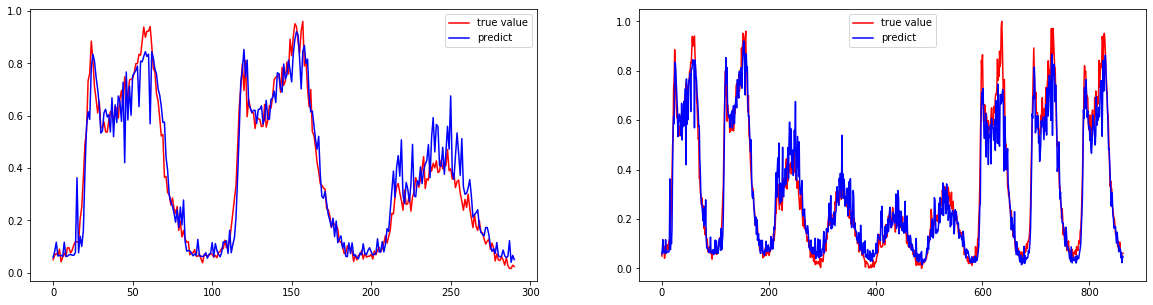

Epoch: 2000, Loss: 0.00253


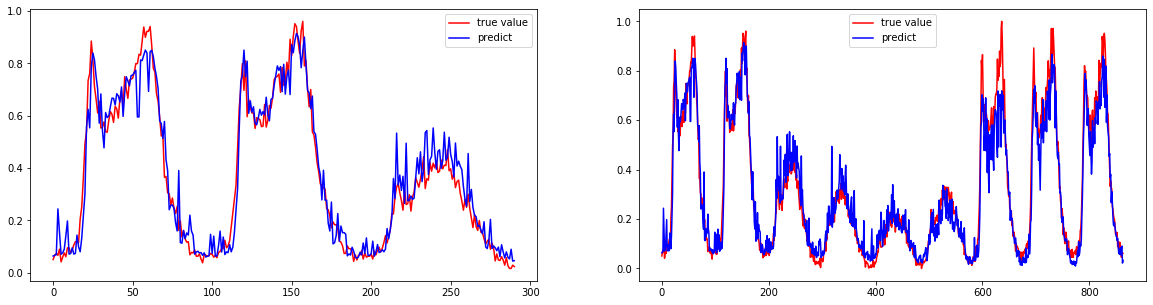

Epoch: 2100, Loss: 0.00234


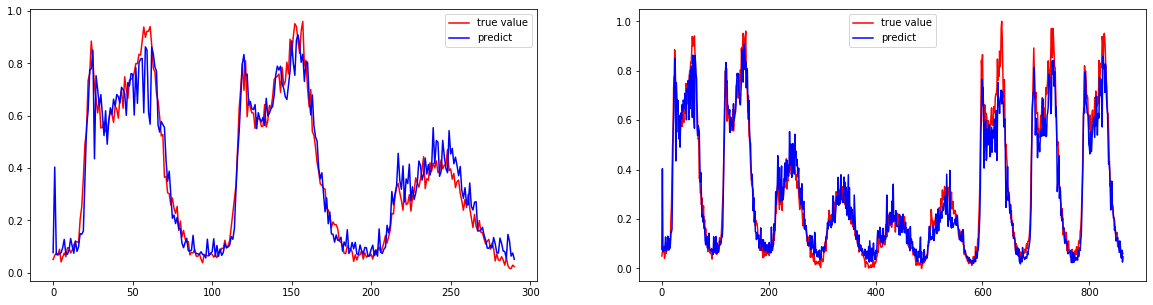

Epoch: 2200, Loss: 0.00218


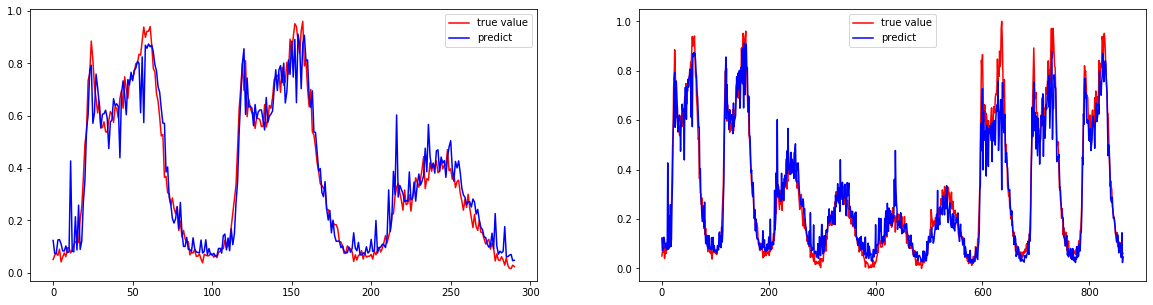

Epoch: 2300, Loss: 0.00243


Epoch: 2400, Loss: 0.00216


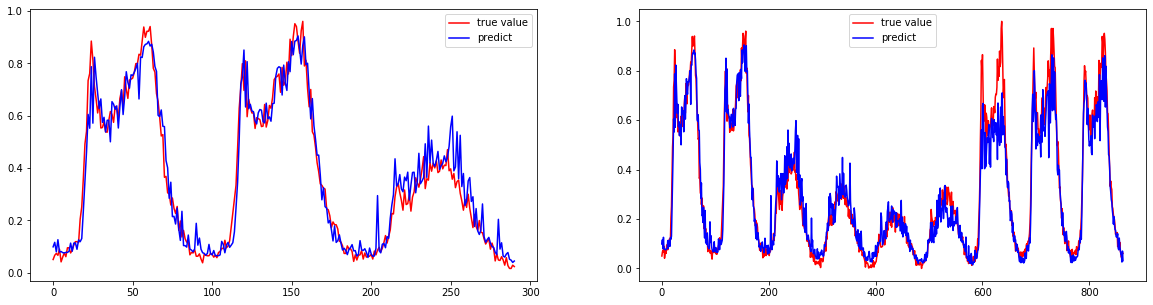

Epoch: 2500, Loss: 0.00219


Epoch: 2600, Loss: 0.00229


Epoch: 2700, Loss: 0.00214


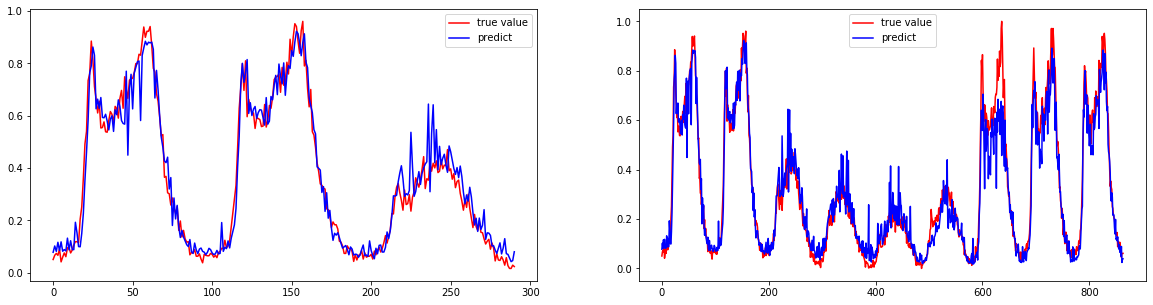

Epoch: 2800, Loss: 0.00229


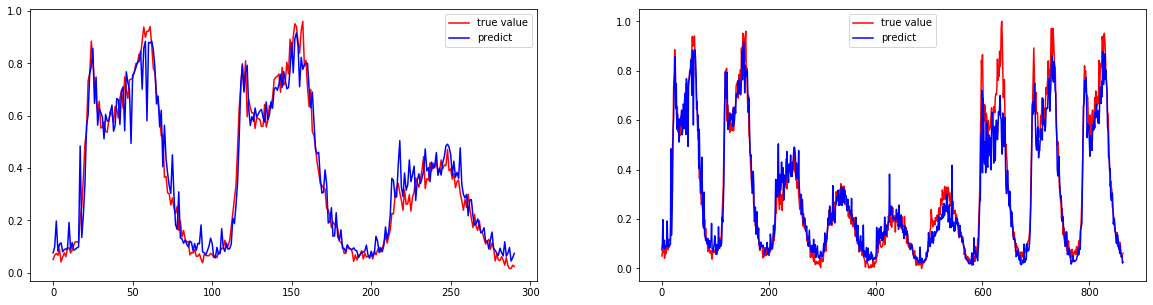

Epoch: 2900, Loss: 0.00203


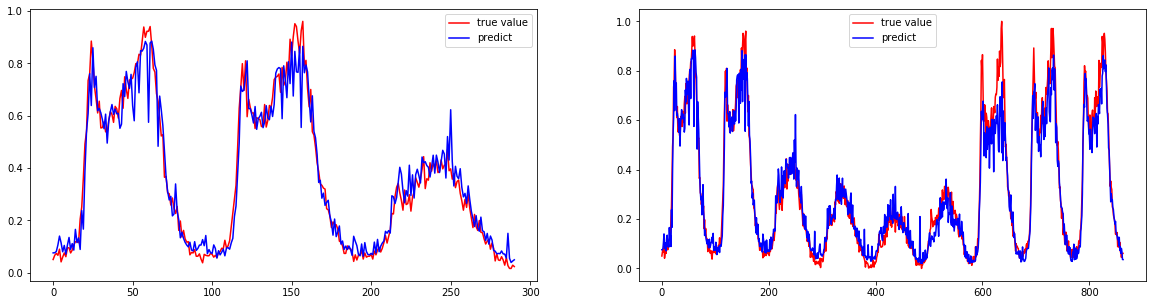

Epoch: 3000, Loss: 0.00209


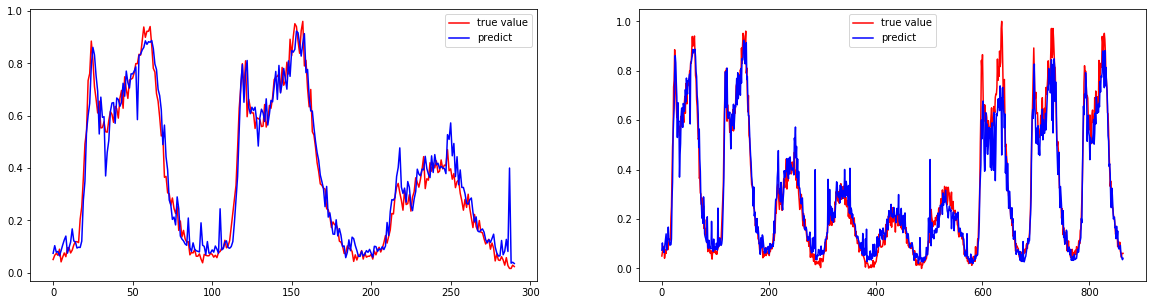

Epoch: 3100, Loss: 0.00220


Epoch: 3200, Loss: 0.00221


Epoch: 3300, Loss: 0.00216


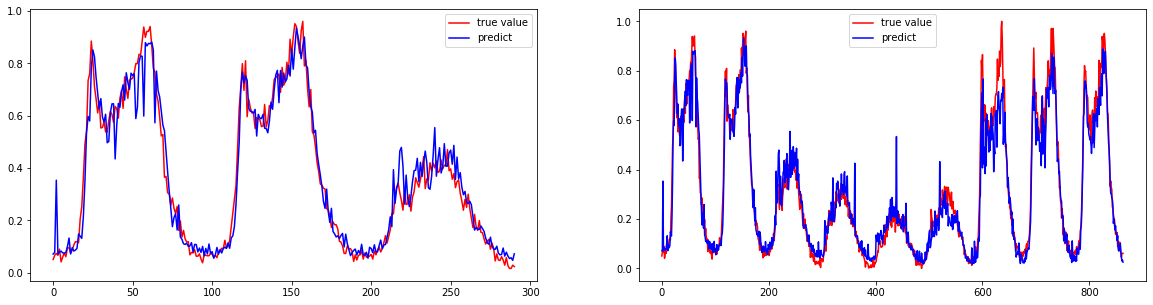

Epoch: 3400, Loss: 0.00208


Epoch: 3500, Loss: 0.00210


Epoch: 3600, Loss: 0.00205


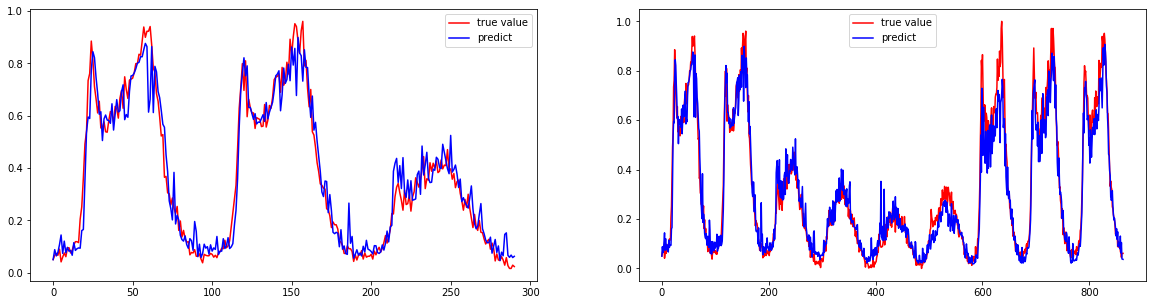

Epoch: 3700, Loss: 0.00209


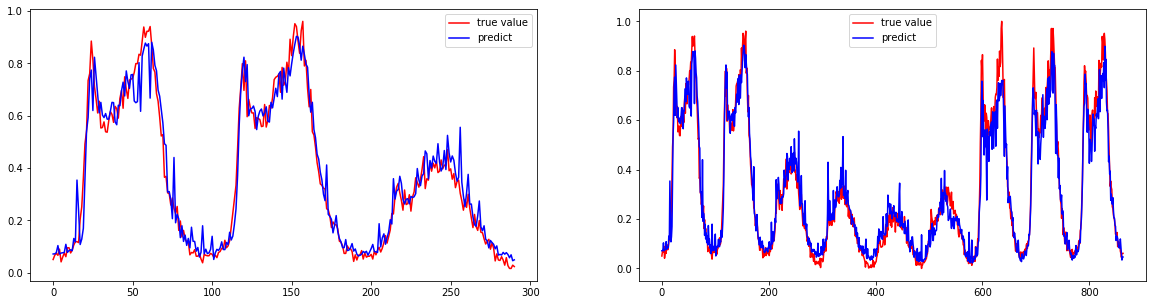

Epoch: 3800, Loss: 0.00202


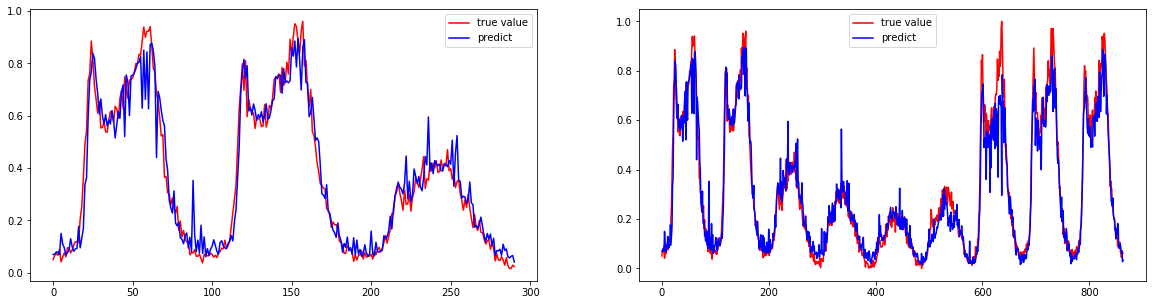

Epoch: 3900, Loss: 0.00202


Epoch: 4000, Loss: 0.00200


Epoch: 4100, Loss: 0.00199


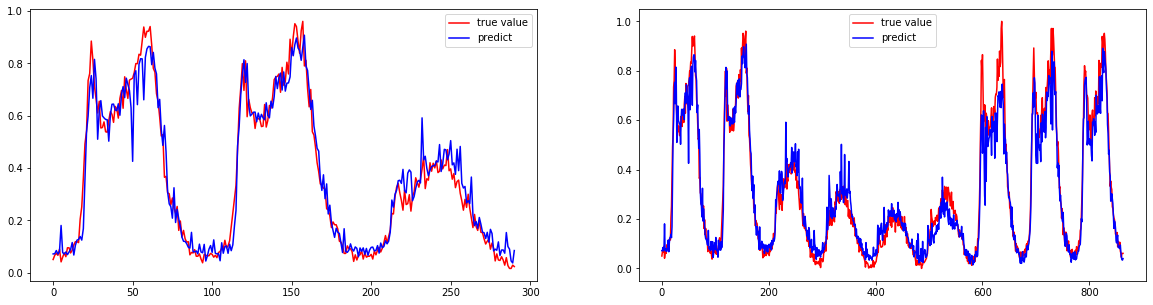

Epoch: 4200, Loss: 0.00197


Epoch: 4300, Loss: 0.00185


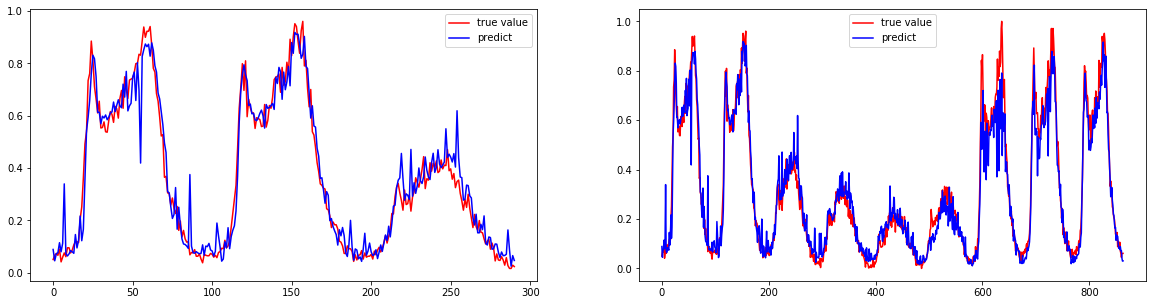

Epoch: 4400, Loss: 0.00187


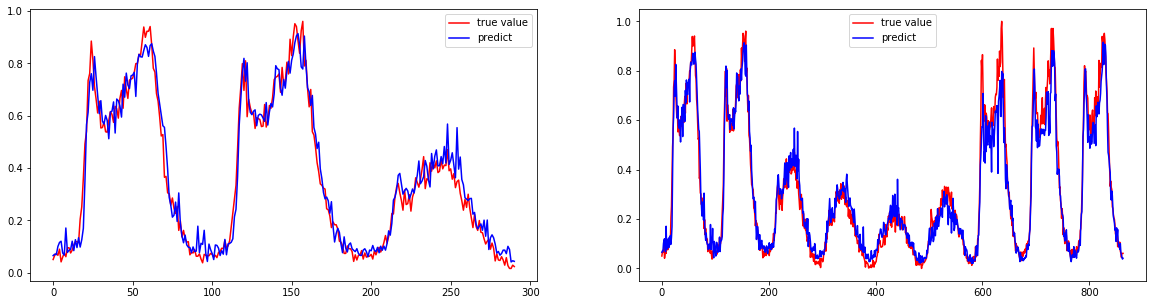

Epoch: 4500, Loss: 0.00204


Epoch: 4600, Loss: 0.00200


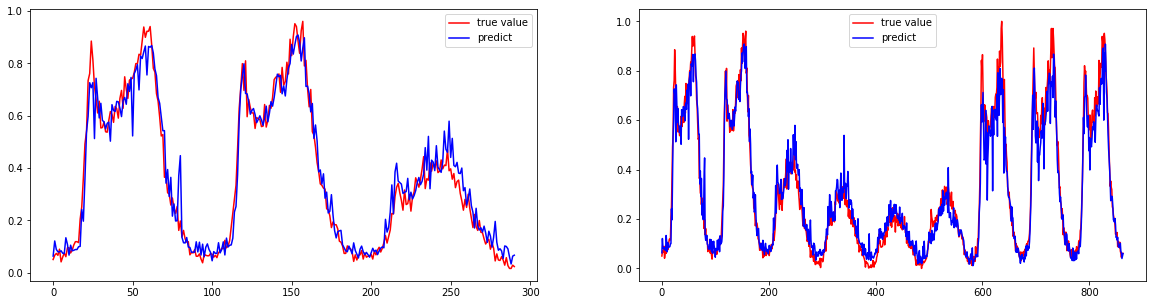

Epoch: 4700, Loss: 0.00188


Epoch: 4800, Loss: 0.00190


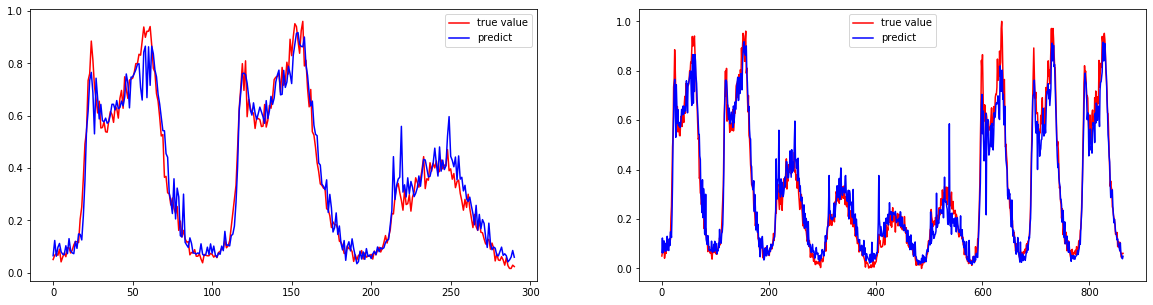

Epoch: 4900, Loss: 0.00195


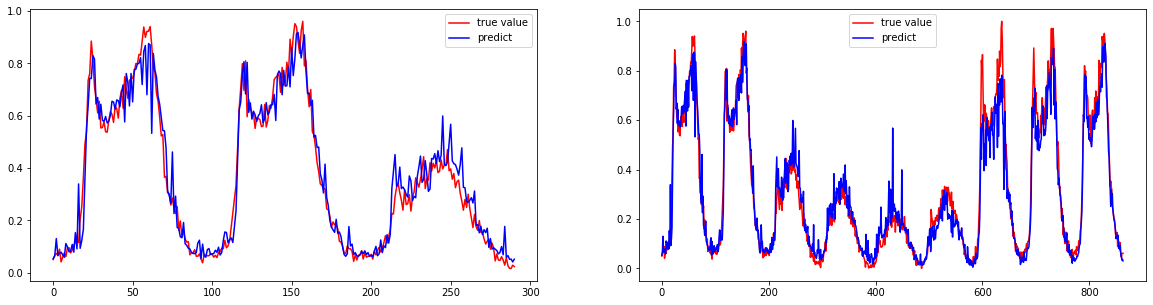

In [13]:
# train
train_x = train_x.reshape(-1, batch_size, inp_dim)
train_y = train_y.reshape(-1, batch_size, label_dim)
test_x = test_x.reshape(-1, batch_size, inp_dim)
test_y = test_y.reshape(-1, batch_size, label_dim)

train_x = torch.tensor(train_x, dtype=torch.float32, device=device)
train_y = torch.tensor(train_y, dtype=torch.float32, device=device)
test_x = torch.tensor(test_x, dtype=torch.float32, device=device)
test_y = torch.tensor(test_y, dtype=torch.float32, device=device)

num_epoch = 5000

for e in range(num_epoch):
    out = net(train_x)
    
    loss = (out - train_y) ** 2
    loss = loss.mean()
    
    optimizer.zero_grad()
    loss.backward()
    
    optimizer.step()
    
    if e%100==0:
        print('Epoch: {:4}, Loss: {:.5f}'.format(e, loss.item()))
        #scheduler.step()
        
        # test
        num_day = 3
        pred_y = net(test_x)[:, :, 0].detach().numpy().flatten()
        ground_truth = test_y[:, :, 0].detach().numpy().flatten()
        ground_truth = normalize(ground_truth)

        fig = plt.figure(figsize=[20, 5])
        ax1 = fig.add_subplot(121)
        ax1.plot(ground_truth[:97*num_day], 'r', label='true value')
        ax1.plot(pred_y[:97*num_day], 'b', label='predict')
        ax1.legend()
        ax2 = fig.add_subplot(122)
        ax2.plot(ground_truth, 'r', label='true value')
        ax2.plot(pred_y, 'b', label='predict')
        ax2.legend()
        plt.show()